In [80]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register

import random


In [81]:
train_data = pd.read_csv('data/train_processed.csv')
val_data = pd.read_csv('data/val.csv')

In [82]:
#Create a (prices, hour) df

hour_prices_df = train_data[['prices', 'hour']]
hours_prices={}
for hour in range(24):
    hour_prices=[]
    for index, row in hour_prices_df.iterrows():
        if int(row['hour'])==hour:
            hour_prices.append(row['prices'])
    hours_prices[hour] = hour_prices

In [83]:
df = pd.DataFrame.from_records(hours_prices)
df2 = pd.read_excel('data/train.xlsx')
df.describe(include="all")
df2.tail()

,PRICES,Hour 01,Hour 02,Hour 03,Hour 04,Hour 05,Hour 06,Hour 07,Hour 08,Hour 09,...,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24
1091,2009-12-27,27.99,21.00,14.00,5.00,0.01,0.01,0.01,0.01,0.01,...,25.00,19.11,17.69,34.99,44.43,44.50,44.00,36.32,39.93,32.00
1092,2009-12-28,19.04,20.55,20.00,11.94,9.99,13.31,18.31,29.52,35.77,...,38.03,37.00,39.63,55.29,56.18,45.88,41.30,36.44,38.20,34.00
1093,2009-12-29,28.50,25.55,22.86,17.00,16.58,19.78,26.91,33.90,34.89,...,34.87,29.01,28.41,42.30,47.45,43.62,38.62,31.27,35.00,30.08
1094,2009-12-30,21.21,16.73,12.66,9.50,9.04,9.78,16.30,24.36,34.00,...,38.41,32.00,33.37,44.99,48.00,42.00,34.01,28.18,33.00,27.99
1095,2009-12-31,17.63,12.15,10.21,8.89,8.36,9.82,11.65,22.14,30.00,...,33.00,29.82,30.28,40.00,40.48,36.00,29.00,24.82,31.28,31.00


In [84]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1091,27.99,21.00,14.00,5.00,0.01,0.01,0.01,0.01,0.01,18.00,...,25.00,19.11,17.69,34.99,44.43,44.50,44.00,36.32,39.93,32.00
1092,19.04,20.55,20.00,11.94,9.99,13.31,18.31,29.52,35.77,41.00,...,38.03,37.00,39.63,55.29,56.18,45.88,41.30,36.44,38.20,34.00
1093,28.50,25.55,22.86,17.00,16.58,19.78,26.91,33.90,34.89,37.10,...,34.87,29.01,28.41,42.30,47.45,43.62,38.62,31.27,35.00,30.08
1094,21.21,16.73,12.66,9.50,9.04,9.78,16.30,24.36,34.00,38.01,...,38.41,32.00,33.37,44.99,48.00,42.00,34.01,28.18,33.00,27.99
1095,17.63,12.15,10.21,8.89,8.36,9.82,11.65,22.14,30.00,34.00,...,33.00,29.82,30.28,40.00,40.48,36.00,29.00,24.82,31.28,31.00


In [85]:
means=df.mean()
means
#From means we can say:
# 10 11 18 should be hours to sell
# 3 4 5 should be hours to buy


0     38.838120
1     33.993558
2     30.053896
3     24.881168
4     23.124434
5     28.803768
6     36.652199
7     50.544790
8     56.924398
9     63.911743
10    67.132427
11    70.883732
12    64.995155
13    61.618257
14    58.981095
15    54.614881
16    53.981651
17    60.162509
18    67.466077
19    62.436697
20    58.464252
21    50.285712
22    50.451268
23    45.259334
dtype: float64

In [86]:
maxs=df.max()
maxs
#18 19 20

0      500.00
1      180.00
2      200.00
3      160.00
4      160.00
5      160.00
6      150.50
7      179.32
8      227.13
9      500.00
10     800.00
11     950.00
12     350.14
13     520.01
14     950.00
15     950.00
16     950.00
17     769.47
18    1762.54
19    1066.82
20    2500.00
21     300.03
22     180.00
23     210.10
dtype: float64

In [87]:
class Dam():

    def __init__(self, observation_data: pd.DataFrame):
        self.data = observation_data
        self.flow_rate = 18000
        self.sell_efficiency = 0.9
        self.buy_efficiency = 0.8
        self.water_capacity = self.flow_rate * 21
        self.conversion_factor = 1000 * 9.81 * 30 * (2 + (7/9)) * (10 ** -10)

    def _get_obs(self):
        self.hour = self.data["hour"].iloc[self.index]
        self.day = self.data["day"].iloc[self.index]
        self.week = self.data["week"].iloc[self.index]
        self.month = self.data["month"].iloc[self.index]
        self.electricity_cost = self.data["prices"].iloc[self.index]

        return {
            "time_hour": self.hour, 
            "time_day": self.day,
            "time_week": self.week,
            "time_month": self.month,
            "water_level": self.water_level,
            "electricity_cost": self.electricity_cost,
            "cash": self.cash,
            "value": self.value
        }
    
    def _get_info(self):
        return {
            "profit": (self.cash - self.starting_cash),
            "unrealized_profit": self.water_level * self.electricity_cost * self.sell_efficiency * self.conversion_factor,
            "total_value": (self.cash - self.starting_cash) + (self.water_level * self.electricity_cost * self.sell_efficiency * self.conversion_factor)
            }
    
    def step(self, action, terminated=False):
        info = self._get_info()
        previous_total_value = info["total_value"]
        # first check if simulation terminates, otherwise move index and perform action
        if (self.index+1) == self.data.shape[0] or (self.water_level == 0 and self.cash == 0):
            terminated = True
        else:
            # otherwise continue
            self.index += 1

            # we can only sell if there is water in the dam
            if action == 'sell' and self.water_level != 0:
                if self.water_level > self.flow_rate:
                    self.cash += self.electricity_cost * self.sell_efficiency * self.flow_rate * self.conversion_factor
                    self.water_level -= self.flow_rate
                else:
                    self.cash += self.electricity_cost * self.sell_efficiency * self.water_level * self.conversion_factor
                    self.water_level = 0
                    
            # we can only buy if we have cash and if dam is not full
            elif action == 'buy' and (self.water_level < self.water_capacity):
                if (self.water_capacity - self.water_level) > self.flow_rate:
                    self.cash -= self.electricity_cost * self.flow_rate * self.conversion_factor / self.buy_efficiency
                    self.water_level += self.flow_rate
                else:
                    self.cash -= self.electricity_cost * (self.water_capacity - self.water_level) * self.conversion_factor / self.buy_efficiency
                    self.water_level = self.water_capacity
                    
        observation = self._get_obs()
        info = self._get_info()
        self.value = info["total_value"]
        if self.value > previous_total_value:
            reward = 1
        else:
            reward = -1
        return observation, reward, terminated, False, info

    def reset(self):
        self.index = 0
        self.hour = self.data["hour"].iloc[self.index]
        self.day = self.data["day"].iloc[self.index]
        self.week = self.data["week"].iloc[self.index]
        self.month = self.data["month"].iloc[self.index]

        self.water_level = 50000  # half of maximum water level
        self.starting_cash = 0  # (arbitrary) amount of cash
        self.cash = self.starting_cash
        self.electricity_cost = self.data["prices"].iloc[self.index]
        self.value = self.starting_cash + (self.electricity_cost * self.water_level)
        
        observation = self._get_obs()
        info = self._get_info()
        return observation, info


In [88]:
dam=Dam(val_data)
buy_hours=[1,2,3,4,5,6]
sell_hours=[9,10,11,12,18,19]
# 10 11 18 should be hours to sell
# 3 4 5 should be hours to buy

In [89]:
def evaluate():
    init_obs = dam.reset()
    rewards = 0
    action_sequence, cash, water_level, all_rewards = [], [], [], []
    for i in range(len(val_data)):
        obs = dam._get_obs()
        #buy with 0.3 prob
        # if obs['time_hour'] in buy_hours :
        if obs['time_hour'] in buy_hours and np.random.uniform(0,1) > 0.0:
            action='buy'
        # elif obs['time_hour'] in sell_hours:
        elif obs['time_hour'] in sell_hours and np.random.uniform(0,1) > 0.0:
            action='sell'
        else:
            action='hold'
        action_sequence.append(action)
        next_state, reward, terminated, truncated, info = dam.step(action)
        rewards += reward
        water_level.append(next_state["water_level"])
        all_rewards.append(rewards)
        cash.append(info["profit"])

    print('The evaluation is done!')
    return action_sequence, cash, all_rewards, water_level

In [90]:
actions, cash, rewards, water_level = evaluate()

df = pd.DataFrame({"prices": val_data["prices"], 'actions': actions, "cash": cash, "water_level": water_level, "rewards": rewards})
df.to_csv('data/eval.csv')


The evaluation is done!


<AxesSubplot: >

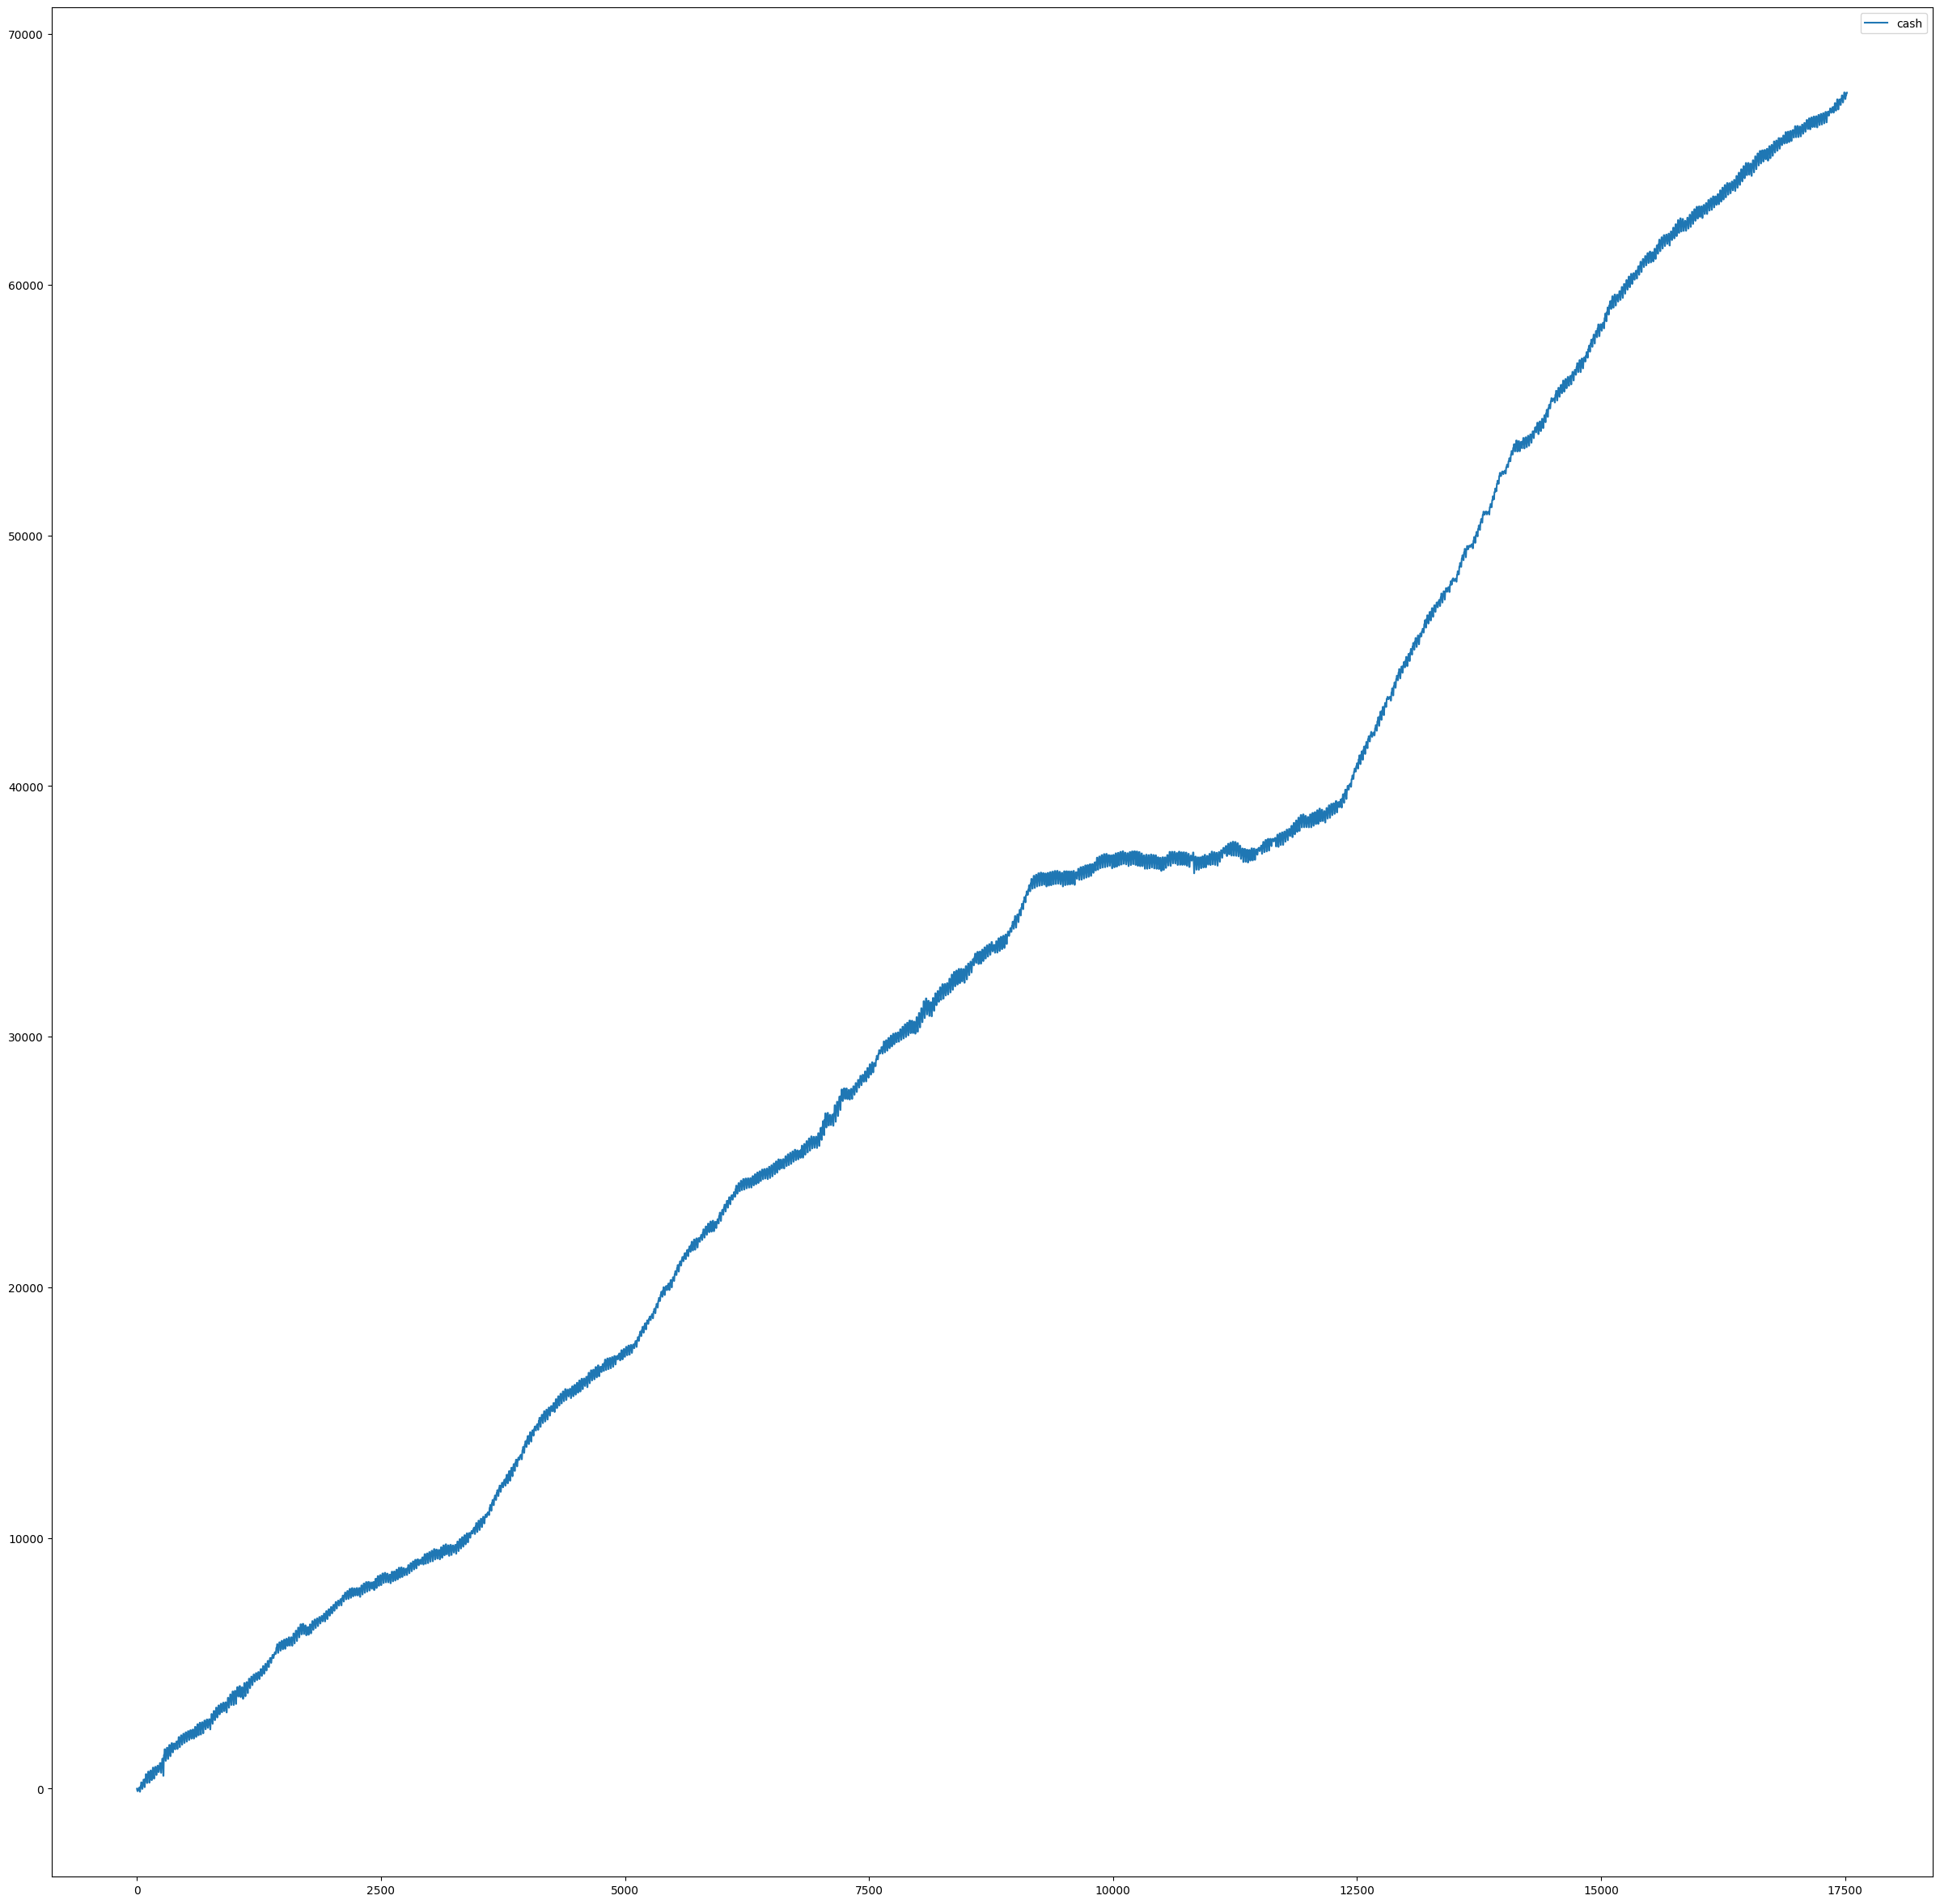

In [91]:
df.plot(x=None, y="cash", kind="line", figsize=(30, 30))